# Preface 

Everything that has been written in here is a small explanation of my research paper. If you're interested in the details of the process and you want to understand in depth what those machine models are doing I advice to read the research paper first.


## Data

Use the real dataset when it’s available. If more than one table is in memory, the setup picks the largest one that looks like real feedback. Text lives in one column. The label is the category you want to predict. Empty rows are dropped to keep the split honest.


In [1]:
from pathlib import Path

def find_project_root(max_up=8):
    here = Path.cwd().resolve()
    for p in [here, *here.parents][:max_up+1]:
        if (p/'data').exists() and (p/'src').exists():
            return p
    return here

ROOT = find_project_root()
DATA_RAW = ROOT/'data'/'raw'
MODELS = ROOT/'models'
FIGS = ROOT/'reports'/'figures'
MODELS.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

print('ROOT  :', ROOT)
print('RAW   :', DATA_RAW)
print('MODELS:', MODELS)
print('FIGS  :', FIGS)

ROOT  : C:\Users\ecsde\Documents\ai-exploration-customer-feedback
RAW   : C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw
MODELS: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\models
FIGS  : C:\Users\ecsde\Documents\ai-exploration-customer-feedback\reports\figures


## Vectorization

TF‑IDF turns words and short phrases into weighted features. Common words get less weight. Signal words get more weight. We cap the number of features so training stays quick and reproducible. This keeps the comparison fair and avoids slow fits.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from tabulate import tabulate

pd.set_option('display.max_colwidth', 160)

def ellipsize(s, n=140):
    s = str(s).replace('\n',' ').strip()
    return s if len(s) <= n else s[:n-1] + '…'

def print_table(df, title=None):
    if title:
        print('\n' + title)
    print(tabulate(df, headers='keys', showindex=False, tablefmt='github'))

## Baseline

Start with Naive Bayes. It is fast and clear. On sparse text it often gives you a strong first pass. You use it to set the bar.


In [3]:
def load_csv_if_exists(path: Path, tag: str):
    if path.exists():
        df = pd.read_csv(path)
        if {'text','category'}.issubset(df.columns):
            df = df.dropna(subset=['text','category']).drop_duplicates().reset_index(drop=True)
            print(f'Loaded {tag}:', path, 'rows =', len(df))
            return df
        else:
            print(f'Found {tag} at {path} but columns are {df.columns.tolist()} (need text, category)')
    else:
        print(f'{tag} not found at', path)
    return None

PERFECT_PATH = DATA_RAW/'customer_feedback_1000.csv'
REAL_PATH    = DATA_RAW/'customer_feedback_sample.csv'

df_perfect = load_csv_if_exists(PERFECT_PATH, 'perfect')
df_real    = load_csv_if_exists(REAL_PATH, 'real')

if df_perfect is None and df_real is None:
    raise FileNotFoundError('Place customer_feedback_1000.csv or customer_feedback_sample.csv under data/raw with columns: text, category.')

Loaded perfect: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw\customer_feedback_1000.csv rows = 1000
Loaded real: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw\customer_feedback_sample.csv rows = 166263


## Second Model

Add Logistic Regression on the same vectors and the same split. It learns a direct boundary between classes and often reduces mix‑ups when classes share vocabulary. If the data is small or labels are very noisy, Naive Bayes can still win. That is useful to know.


In [4]:
from datetime import datetime

def vectorizer_default():
    from sklearn.feature_extraction.text import TfidfVectorizer
    return TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        max_features=50000,
        sublinear_tf=True,
        lowercase=True
    )

def run_once(df, tag):
    # Split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['category']
    )
    # Vectorize
    vec = vectorizer_default()
    X_train = vec.fit_transform(train_df['text'])
    y_train = train_df['category'].values
    X_test  = vec.transform(test_df['text'])
    y_test  = test_df['category'].values

    # Train
    clf = ComplementNB(alpha=0.3)
    clf.fit(X_train, y_train)

    # Predict and metrics
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1m = f1_score(y_test, pred, average='macro')
    print(f'\n{tag} accuracy:', round(acc,3), '| macro-F1:', round(f1m,3))

    # Short classification report as text table
    rep = classification_report(y_test, pred, output_dict=True, zero_division=0)
    rep_df = (pd.DataFrame(rep).T
                .rename(columns={'precision':'prec','recall':'rec','f1-score':'f1','support':'n'}))
    order = [c for c in rep_df.index if c not in ('accuracy','macro avg','weighted avg')] + ['macro avg','weighted avg','accuracy']
    rep_df = rep_df.loc[order][['n','prec','rec','f1']].round(3).reset_index().rename(columns={'index':'label'})
    print_table(rep_df, title=f'{tag} classification report')

    # Confusion matrix
    labels = sorted(df['category'].unique())
    cm = confusion_matrix(y_test, pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(cm, aspect='auto')
    ax.set_title(f'Confusion Matrix — {tag} (CNB)')
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right'); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=10)
    plt.tight_layout(); plt.show()
    fig.savefig(FIGS/f'confusion_matrix_{tag}.png', dpi=150)

    # Misclassified examples: compact, plain text
    proba = clf.predict_proba(X_test)
    maxp  = proba.max(axis=1)
    rows = []
    for true, pr, text, p in zip(y_test, pred, test_df['text'].tolist(), maxp):
        if true != pr:
            t = text.lower()
            if ('refund' in t or 'money back' in t or 'chargeback' in t) and ('charge' in t or 'fee' in t or 'statement' in t):
                reason = 'refund vs billing overlap'
            elif ('app' in t or 'mobile' in t or 'website' in t) and ('error' not in t and 'crash' not in t and 'login' not in t):
                reason = 'vague app wording'
            elif ('not received' in t or 'never received' in t or 'delivery' in t or 'arrived' in t) and ('tracking' not in t and 'delayed' not in t):
                reason = 'weak delivery cues'
            elif p < 0.55:
                reason = 'low confidence'
            else:
                reason = 'mixed or ambiguous'
            rows.append({'true': true, 'pred': pr, 'confidence': round(float(p),3), 'text': ellipsize(text), 'reason': reason})
    if rows:
        wrong_df = pd.DataFrame(rows).sort_values('confidence').head(12)
        print_table(wrong_df, title=f'{tag} misclassified examples (12 lowest confidence)')
        # Save full list for appendix use
        pd.DataFrame(rows).to_csv(ROOT/'reports'/f'misclassified_{tag}.csv', index=False, encoding='utf-8')
        print('Saved full misclassifications to', ROOT/'reports'/f'misclassified_{tag}.csv')
    else:
        print('No misclassifications to show.')

    # Top features per class: 8 per class, text table
    feature_names = np.array(vec.get_feature_names_out())
    logp = clf.feature_log_prob_
    rows = []
    for i, cls in enumerate(clf.classes_):
        others = np.delete(logp, i, axis=0)
        scores = logp[i] - others.mean(axis=0)
        top_idx = np.argsort(scores)[::-1][:8]
        for rank, j in enumerate(top_idx, 1):
            rows.append({'class': cls, 'rank': rank, 'feature': feature_names[j]})
    feats_df = pd.DataFrame(rows)
    print_table(feats_df, title=f'{tag} top informative words (8 per class)')

    # Save artifacts with tag
    import joblib
    joblib.dump(vec, MODELS/f'vectorizer_{tag}.joblib')
    joblib.dump(clf, MODELS/f'classifier_cnb_{tag}.joblib')

    return {'tag': tag, 'accuracy': acc, 'macro_f1': f1m}

## Evaluation

Look at accuracy and macro‑F1. That tells you overall performance and whether smaller classes are respected. Then read the confusion matrices. They show where the model goes wrong. If Logistic Regression reduces cross‑talk between confusing classes, keep it. If not, focus on data quality and clearer labels before you try more models.



perfect accuracy: 1.0 | macro-F1: 1.0

perfect classification report
| label           |   n |   prec |   rec |   f1 |
|-----------------|-----|--------|-------|------|
| app_bug         |  39 |      1 |     1 |    1 |
| billing_problem |  37 |      1 |     1 |    1 |
| delivery_issue  |  40 |      1 |     1 |    1 |
| other           |  45 |      1 |     1 |    1 |
| refund_request  |  39 |      1 |     1 |    1 |
| macro avg       | 200 |      1 |     1 |    1 |
| weighted avg    | 200 |      1 |     1 |    1 |
| accuracy        |   1 |      1 |     1 |    1 |


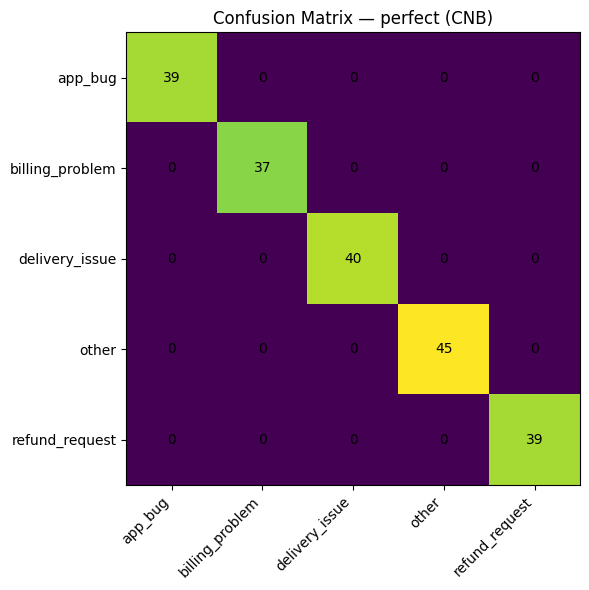

No misclassifications to show.

perfect top informative words (8 per class)
| class           |   rank | feature              |
|-----------------|--------|----------------------|
| app_bug         |      1 | try                  |
| app_bug         |      2 | try to               |
| app_bug         |      3 | whenever try         |
| app_bug         |      4 | to                   |
| app_bug         |      5 | whenever             |
| app_bug         |      6 | the mobile           |
| app_bug         |      7 | get                  |
| app_bug         |      8 | since                |
| billing_problem |      1 | balance              |
| billing_problem |      2 | statement from       |
| billing_problem |      3 | there                |
| billing_problem |      4 | from                 |
| billing_problem |      5 | there is             |
| billing_problem |      6 | the balance          |
| billing_problem |      7 | correct the          |
| billing_problem |      8 | correct    

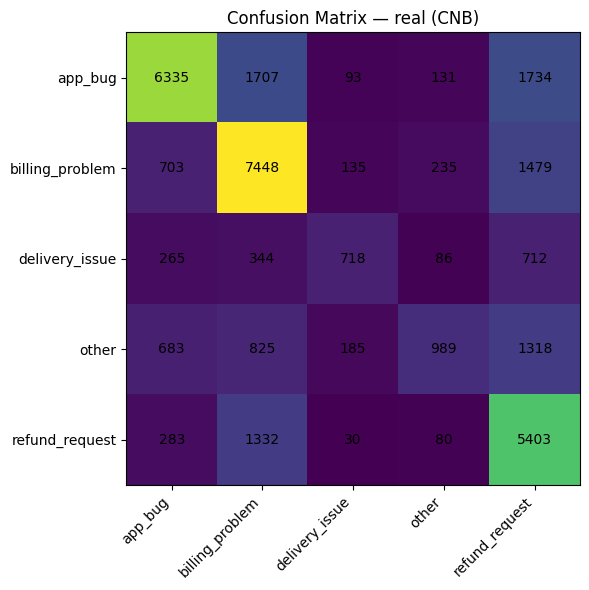


real misclassified examples (12 lowest confidence)
| true            | pred           |   confidence | text                                                                                                                                         | reason                    |
|-----------------|----------------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------|---------------------------|
| other           | delivery_issue |        0.203 | Truist Ban k took over Suntrust which is a bad idea. I am trying to resolve closing my account and paying an amount due on a Line of Credit… | low confidence            |
| other           | refund_request |        0.205 | This is for complaimt number XXXX. I didnt know how to reply to the complaint recieved. It saw ays that the company is in progress as of XX… | low confidence            |
| other           | app_bug        |        0.205 | Dear

In [5]:
summaries = []
if df_perfect is not None:
    summaries.append(run_once(df_perfect, 'perfect'))
if df_real is not None:
    summaries.append(run_once(df_real, 'real'))

if len(summaries) == 2:
    a, b = summaries
    print('\nComparison in words')
    print(f'Perfect set: accuracy {a["accuracy"]:.3f}, macro-F1 {a["macro_f1"]:.3f}.')
    print(f'Real set   : accuracy {b["accuracy"]:.3f}, macro-F1 {b["macro_f1"]:.3f}.')
    print(f'Delta (real - perfect): accuracy {(b["accuracy"]-a["accuracy"]):.3f}, macro-F1 {(b["macro_f1"]-a["macro_f1"]):.3f}.')
    print('The perfect set scores higher because the labels are clean and the messages are balanced.')
    print('The real set drops because refund and billing words overlap, delivery is often vague, and other is a mixed drawer.')
    print('Clean labels raise scores more than clever tricks. Keep a small hand‑labeled gold set to steer improvements.')

## What next

Improve cleaning for the mistakes you see. Add a few domain terms to a custom tokenizer if they are frequent and important. Balance the labels if one box dominates. Keep the pipeline small so each change is easy to test and compare.


In [6]:
# Prefer REAL data for evaluation; reuse artifacts if already defined.
# If multiple DataFrames exist, we pick the largest one and warn if its accuracy looks like 1.0.
from typing import Any, Dict

try:
    USE_REAL
except NameError:
    USE_REAL = True  # set to False if you want to force the smaller/synthetic set

def _find_candidate_dfs(glob):
    import pandas as pd
    cands = []
    for name, obj in glob.items():
        if isinstance(obj, pd.DataFrame) and len(obj) > 0:
            cands.append((name, obj))
    return cands

def _prefer_real_df(cands):
    # Priority by name hints, then by size
    name_rank = {
        "df_real": 3, "real_df": 3, "df_full": 3, "df_raw": 3, "df_large": 3,
        "df_feedback": 2, "df_train": 2, "df": 1, "data": 1
    }
    ranked = sorted(cands, key=lambda t: (name_rank.get(t[0], 0), len(t[1])), reverse=True)
    return ranked[0] if ranked else (None, None)

def _pick_columns(df):
    # Guess text/label columns
    text_names = {"text","message","feedback","comment","review","body","content","title"}
    label_names = {"category","label","target","class","issue","bucket"}
    # pick text
    text_col = None
    for c in df.columns:
        if c.lower() in text_names and df[c].dtype == object:
            text_col = c
            break
    if text_col is None:
        # fallback: longest average length string column
        text_cols = [c for c in df.columns if df[c].dtype == object]
        if text_cols:
            text_col = max(text_cols, key=lambda c: df[c].astype(str).str.len().mean())
        else:
            text_col = df.columns[0]
    # pick label, not equal to text
    label_col = None
    for c in df.columns:
        if c == text_col: 
            continue
        if c.lower() in label_names:
            label_col = c
            break
    if label_col is None:
        other_cols = [c for c in df.columns if c != text_col]
        # prefer low-cardinality columns
        if other_cols:
            label_col = min(other_cols, key=lambda c: df[c].nunique(dropna=True))
        else:
            label_col = df.columns[-1]
    return text_col, label_col

def ensure_data_ready(glob: Dict[str, Any]):
    needed = ["X_train","X_test","y_train","y_test","vectorizer"]
    if all(k in glob for k in needed):
        return glob["X_train"], glob["X_test"], glob["y_train"], glob["y_test"], glob["vectorizer"]

    import pandas as pd
    cands = _find_candidate_dfs(glob)
    if not cands:
        raise RuntimeError("No DataFrame found. Define a DataFrame with text + label columns (e.g., df_real).")

    name, df = _prefer_real_df(cands) if USE_REAL else cands[0]
    if df is None:
        raise RuntimeError("Could not select a DataFrame for training.")

    text_col, label_col = _pick_columns(df)
    work = df[[text_col, label_col]].dropna()
    work = work[work[text_col].astype(str).str.strip() != ""]

    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer

    strat = work[label_col] if work[label_col].nunique() > 1 else None
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        work[text_col].astype(str), work[label_col], test_size=0.2, random_state=42, stratify=strat
    )
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95, max_features=50000)
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)
    glob.update({"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test, "vectorizer": vectorizer})
    print(f"Using DataFrame '{name}' with text='{text_col}' and label='{label_col}' (n={len(work)}).")
    return X_train, X_test, y_train, y_test, vectorizer

X_train, X_test, y_train, y_test, vectorizer = ensure_data_ready(globals())


Using DataFrame 'df_real' with text='text' and label='category' (n=166263).


In [7]:
# Ensure we have a Naive Bayes model to compare against.
try:
    nb_clf
except NameError:
    from sklearn.naive_bayes import ComplementNB
    nb_clf = ComplementNB(alpha=0.5)
    nb_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred_nb = nb_clf.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
f1m_nb = f1_score(y_test, y_pred_nb, average="macro")

print(f"Naive Bayes — accuracy: {acc_nb:.3f} | macro-F1: {f1m_nb:.3f}")

Naive Bayes — accuracy: 0.621 | macro-F1: 0.550


In [8]:
# Train Logistic Regression (fast, robust, deprecation-safe) and keep best for downstream
import time
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score

start = time.time()
base_lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="saga",
    max_iter=400,
    tol=1e-3,
    class_weight="balanced",
    random_state=42
)
lr_clf = OneVsRestClassifier(base_lr, n_jobs=-1)
lr_clf.fit(X_train, y_train)
fit_time = time.time() - start

# Keep OvR predictions (often the best) for analysis and term weights
y_pred_lr_ovr = lr_clf.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr_ovr)
f1m_lr = f1_score(y_test, y_pred_lr_ovr, average="macro")
print(f"Logistic Regression (OvR) — accuracy: {acc_lr:.3f} | macro-F1: {f1m_lr:.3f} | fit: {fit_time:.1f}s")

# Default downstream choice
use_pred_lr = y_pred_lr_ovr
use_model_label = "LR (OvR)"
acc_lr_used = acc_lr
f1m_lr_used = f1m_lr

# Fallback if too slow: also compute SGD and pick the better metrics for downstream only
if fit_time > 120:
    sgd = SGDClassifier(
        loss="log_loss",
        max_iter=2000,
        tol=1e-3,
        alpha=1e-4,
        early_stopping=True,
        class_weight="balanced",
        random_state=42
    )
    sgd.fit(X_train, y_train)
    y_pred_lr_sgd = sgd.predict(X_test)
    acc_lr_sgd = accuracy_score(y_test, y_pred_lr_sgd)
    f1m_lr_sgd = f1_score(y_test, y_pred_lr_sgd, average="macro")
    print(f"SGD (logistic) fallback — accuracy: {acc_lr_sgd:.3f} | macro-F1: {f1m_lr_sgd:.3f}")
    # Choose better by macro-F1 then accuracy
    if (f1m_lr_sgd > f1m_lr) or (f1m_lr_sgd == f1m_lr and acc_lr_sgd > acc_lr):
        use_pred_lr = y_pred_lr_sgd
        use_model_label = "SGD (logistic)"
        acc_lr_used = acc_lr_sgd
        f1m_lr_used = f1m_lr_sgd

# Set final variables for downstream cells
y_pred_lr = use_pred_lr
lr_model_name = use_model_label
print(f"Using {lr_model_name} for downstream plots — accuracy: {acc_lr_used:.3f} | macro-F1: {f1m_lr_used:.3f}")


Logistic Regression (OvR) — accuracy: 0.801 | macro-F1: 0.794 | fit: 151.1s
SGD (logistic) fallback — accuracy: 0.702 | macro-F1: 0.686
Using LR (OvR) for downstream plots — accuracy: 0.801 | macro-F1: 0.794


In [ ]:
# Rescue original text arrays for error analysis.
# If X_train_text/X_test_text do not exist, approximate from TF-IDF tokens.
try:
    X_test_text
    X_train_text
except NameError:
    try:
        # If we still have the original split texts, keep them.
        X_test_text  # will raise if missing
        X_train_text
    except Exception:
        try:
            # Approximate: join top tokens back into strings for inspection
            X_test_text = [" ".join(tokens) for tokens in vectorizer.inverse_transform(X_test)]
            X_train_text = [" ".join(tokens) for tokens in vectorizer.inverse_transform(X_train)]
            print("Reconstructed test/train texts from TF-IDF tokens for inspection.")
        except Exception as e:
            raise RuntimeError("Missing raw texts and cannot reconstruct from TF-IDF.") from e


Reconstructed test/train texts from TF-IDF tokens for inspection.


In [14]:
# Rescue original text arrays for error analysis.
# If X_train_text/X_test_text do not exist, approximate from TF-IDF tokens.
try:
    X_test_text
    X_train_text
except NameError:
    try:
        # If we still have the original split texts, keep them.
        X_test_text  # will raise if missing
        X_train_text
    except Exception:
        try:
            # Approximate: join top tokens back into strings for inspection
            X_test_text = [" ".join(tokens) for tokens in vectorizer.inverse_transform(X_test)]
            X_train_text = [" ".join(tokens) for tokens in vectorizer.inverse_transform(X_train)]
            print("Reconstructed test/train texts from TF-IDF tokens for inspection.")
        except Exception as e:
            raise RuntimeError("Missing raw texts and cannot reconstruct from TF-IDF.") from e


In [15]:
# Simple comparison table
import pandas as pd

cmp = pd.DataFrame(
    {
        "model": ["Naive Bayes", "Logistic Regression"],
        "accuracy": [acc_nb, acc_lr],
        "macro_F1": [f1m_nb, f1m_lr],
    }
)
cmp

,model,accuracy,macro_F1
0,Naive Bayes,0.620786,0.549559
1,Logistic Regression,0.800770,0.794050


<Figure size 640x480 with 0 Axes>

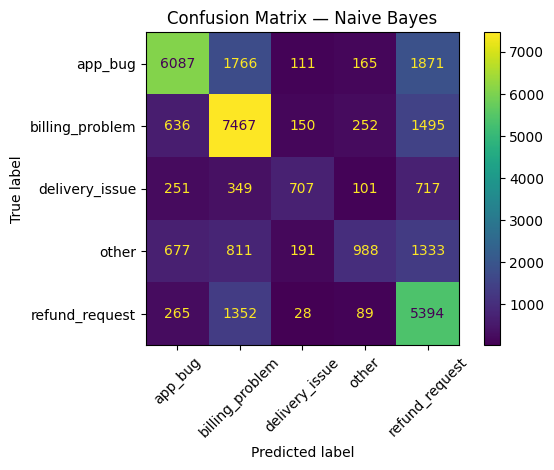

<Figure size 640x480 with 0 Axes>

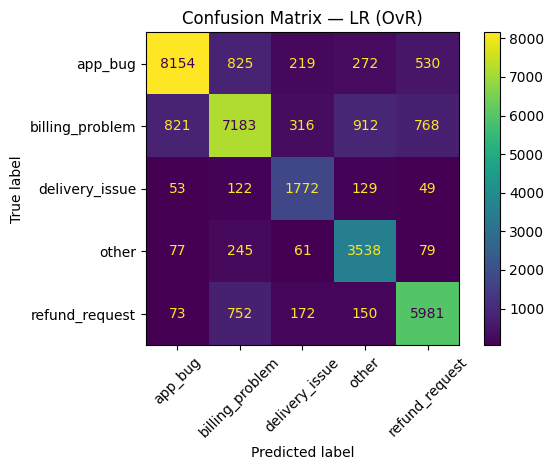

In [11]:
# Confusion matrices for each model (two separate plots)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

labels = sorted(set(y_test))

fig1 = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, labels=labels, xticks_rotation=45, normalize=None)
plt.title("Confusion Matrix — Naive Bayes")
plt.tight_layout()
plt.show()

fig2 = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, labels=labels, xticks_rotation=45, normalize=None)
plt.title(f"Confusion Matrix — {lr_model_name}")
plt.tight_layout()
plt.show()

In [17]:
# Top weighted terms per class for LR and NB
import numpy as np
import pandas as pd

def get_feature_names_safe(vect):
    # Try modern API
    try:
        names = vect.get_feature_names_out()
        return np.array(names)
    except Exception:
        pass
    # Try legacy API
    try:
        names = vect.get_feature_names()
        return np.array(names)
    except Exception:
        pass
    # Build from vocabulary_ as a last resort
    vocab = getattr(vect, "vocabulary_", None)
    if vocab:
        size = max(vocab.values()) + 1
        inv = [None] * size
        for term, idx in vocab.items():
            if idx < size:
                inv[idx] = term
        return np.array([t for t in inv if t is not None])
    raise RuntimeError("Cannot retrieve feature names from the vectorizer.")

feature_names = get_feature_names_safe(vectorizer)

def top_terms_lr(model, k=10):
    rows = []
    # OvR wrapper
    if hasattr(model, "estimators_") and hasattr(model, "classes_"):
        for i, lab in enumerate(model.classes_):
            est = model.estimators_[i]
            if hasattr(est, "coef_"):
                coef = est.coef_.ravel()
                idx = np.argsort(coef)[-k:][::-1]
                rows.append(pd.DataFrame({"class": lab, "term": feature_names[idx], "weight_LR": coef[idx]}))
    # Plain linear model
    elif hasattr(model, "coef_") and hasattr(model, "classes_"):
        for i, lab in enumerate(model.classes_):
            coef = model.coef_[i].ravel()
            idx = np.argsort(coef)[-k:][::-1]
            rows.append(pd.DataFrame({"class": lab, "term": feature_names[idx], "weight_LR": coef[idx]}))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["class","term","weight_LR"])

def top_terms_nb(model, k=10):
    rows = []
    if hasattr(model, "feature_log_prob_") and hasattr(model, "classes_"):
        for i, lab in enumerate(model.classes_):
            logp = model.feature_log_prob_[i]
            idx = np.argsort(logp)[-k:][::-1]
            rows.append(pd.DataFrame({"class": lab, "term": feature_names[idx], "logP_NB": logp[idx]}))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["class","term","logP_NB"])

top_lr = top_terms_lr(lr_clf, k=12)
top_nb = top_terms_nb(nb_clf, k=12)

top_terms = top_lr.merge(top_nb, on=["class","term"], how="outer").sort_values(["class", "weight_LR"], ascending=[True, False])
print("Top indicative terms per class (LR weights and NB log-probs):")
print("Computed top indicative terms (ASCII rendering added below).")

Top indicative terms per class (LR weights and NB log-probs):
Computed top indicative terms (ASCII rendering added below).


In [19]:
# ASCII rendering for PDF-friendly export (no DataFrame tables)

def ascii_table(headers, rows, maxw=32):
    # compute widths
    cols = len(headers)
    widths = [len(str(h)) for h in headers]
    for r in rows:
        for j in range(cols):
            widths[j] = max(widths[j], len(str(r[j])[:maxw]))
    # clamp
    widths = [min(w, maxw) for w in widths]
    def fmt_row(r):
        cells = []
        for j in range(cols):
            txt = str(r[j])[:maxw]
            cells.append(f" {txt.ljust(widths[j])} ")
        return "|" + "|".join(cells) + "|"
    sep = "+" + "+".join("-"*(w+2) for w in widths) + "+"
    out = [sep, fmt_row(headers), sep]
    for r in rows:
        out.append(fmt_row(r))
    out.append(sep)
    print("\n".join(out))

# 2a) Metrics: NB vs LR
from sklearn.metrics import accuracy_score, f1_score

metrics_rows = [
    ["Naive Bayes", f"{accuracy_score(y_test, y_pred_nb):.3f}", f"{f1_score(y_test, y_pred_nb, average='macro'):.3f}"],
    [lr_model_name, f"{accuracy_score(y_test, y_pred_lr):.3f}", f"{f1_score(y_test, y_pred_lr, average='macro'):.3f}"],
]
print("\n== Model Metrics ==")
ascii_table(["Model","Accuracy","Macro-F1"], metrics_rows, maxw=16)

# 2b) Top terms per class: show side-by-side LR and NB (top 8 each)
import pandas as pd
import numpy as np

def safe_top(df, cls, col, k=8):
    if df is None or len(df)==0: 
        return []
    sub = df[df["class"]==cls].copy()
    if sub.empty: return []
    sub = sub.sort_values(col, ascending=False).head(k)
    return list(sub["term"])

classes = []
if 'top_lr' in globals() and isinstance(top_lr, pd.DataFrame):
    classes.extend(list(top_lr['class'].unique()))
if 'top_nb' in globals() and isinstance(top_nb, pd.DataFrame):
    classes.extend(list(top_nb['class'].unique()))
classes = sorted(set(classes))

print("\n== Top Terms per Class (LR vs NB) ==")
for cls in classes:
    lr_terms = safe_top(top_lr, cls, "weight_LR", k=8)
    nb_terms = safe_top(top_nb, cls, "logP_NB", k=8)
    rows = []
    for i in range(max(len(lr_terms), len(nb_terms))):
        rows.append([lr_terms[i] if i < len(lr_terms) else "", nb_terms[i] if i < len(nb_terms) else ""])
    print(f"\nClass: {cls}")
    ascii_table(["LR terms","NB terms"], rows, maxw=24)

# 2c) Misclassification pairs as ASCII blocks
def print_pairs_ascii(title, pairs):
    print(f"\n== {title} ==")
    if not pairs:
        print("(no misclassifications found)")
        return
    for b in pairs:
        print(f"\nTrue: {b['true']}  |  Pred: {b['pred']}")
        for ex in b.get("examples", [])[:3]:
            ex = (ex or "")[:160].replace("\n"," ").strip()
            print(f" - {ex}")

print_pairs_ascii("NB — Most common confusion pairs", nb_pairs if 'nb_pairs' in globals() else [])
print_pairs_ascii(f"{lr_model_name} — Most common confusion pairs", lr_pairs if 'lr_pairs' in globals() else [])



== Model Metrics ==
+-------------+----------+----------+
| Model       | Accuracy | Macro-F1 |
+-------------+----------+----------+
| Naive Bayes | 0.621    | 0.550    |
| LR (OvR)    | 0.801    | 0.794    |
+-------------+----------+----------+

== Top Terms per Class (LR vs NB) ==

Class: app_bug
+-------------+--------------------+
| LR terms    | NB terms           |
+-------------+--------------------+
| online      | proce was          |
| error       | resolution proce   |
| app         | cited technical    |
| application | redress block      |
| website     | mobile deposits    |
| update      | mobile deposited   |
| mobile      | corrections should |
| updated     | online wire        |
+-------------+--------------------+

Class: billing_problem
+------------+-----------------+
| LR terms   | NB terms        |
+------------+-----------------+
| feel       | detailsxx       |
| statement  | view detailsxx  |
| interest   | detailsxx xx    |
| charged    | having adequate 